# **Monet-Style Image Generation using CycleGAN¶**


The goal is to develop and train a Generative Adversarial Network (GAN) model that can produce images in the artistic style of Claude Monet. This could involve transforming existing photographs into Monet’s style or generating entirely new images that emulate his distinctive brushstrokes, color palettes, and overall aesthetic

We will implement a CycleGAN, a type of GAN particularly suited for image-to-image translation tasks where paired training data (e.g., a photo and its exact Monet-style equivalent) is not available. A CycleGAN learns mappings between two distinct image domains (in our case, landscape photographs and Monet paintings) using two generators and two discriminators.

Generator G: Learns to translate photos into Monet-style paintings
Generator F: Learns to translate Monet paintings back into photos
Discriminator D_Y: Tries to distinguish between real Monet paintings and generated (fake) Monet paintings.
Discriminator D_X: Tries to distinguish between real photos and generated (fake) photos.

Dataset: The competition offers two main image sets:

- Monet Paintings: ~300 images (monet_jpg, monet_tfrec) for training the model on Monet’s style.
- Photos: ~7000 landscape photos (photo_jpg, photo_tfrec) to be transformed into Monet style for submission.

Evaluation Metric: Submissions are evaluated using the Memorization-informed Fréchet Inception Distance (MiFID) score.

# Imports


In [ ]:
# --- Imports ---
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import zipfile
from tqdm.notebook import tqdm


# Data Paths (Kaggle)
BASE_PATH = '/kaggle/input/gan-getting-started/'

MONET_TFREC_PATH = os.path.join(BASE_PATH, 'monet_tfrec')
PHOTO_TFREC_PATH = os.path.join(BASE_PATH, 'photo_tfrec')
MONET_JPG_PATH = os.path.join(BASE_PATH, 'monet_jpg')
PHOTO_JPG_PATH = os.path.join(BASE_PATH, 'photo_jpg')

# Model & Training Params
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BUFFER_SIZE = 200 # For shuffling dataset
BATCH_SIZE = 1
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

# Loss weights
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 0.5

# Output directory for generated images
OUTPUT_DIR = "/kaggle/working/images/"
ZIP_FILENAME = "/kaggle/working/images.zip"

2025-06-08 18:38:41.073728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749407921.349996      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749407921.438701      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis (EDA)¶


Inspect the dataset structure, check file counts, verify image dimensions, and visualize some samples.

Number of Monet JPG files found: 300
Number of Photo JPG files found: 7038
Number of Monet TFRecord files found: 5
Number of Photo TFRecord files found: 20


2025-06-08 18:39:02.203781: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


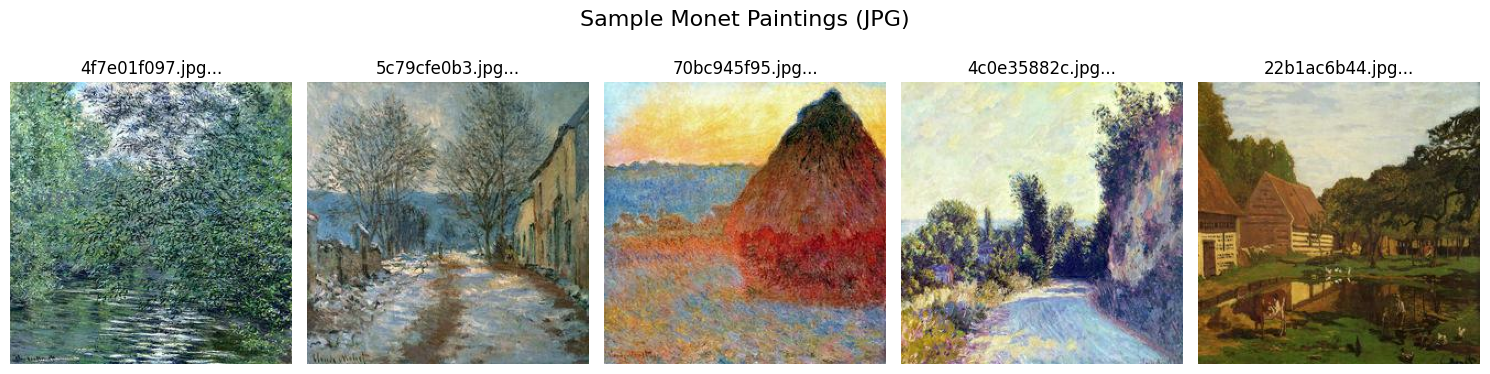

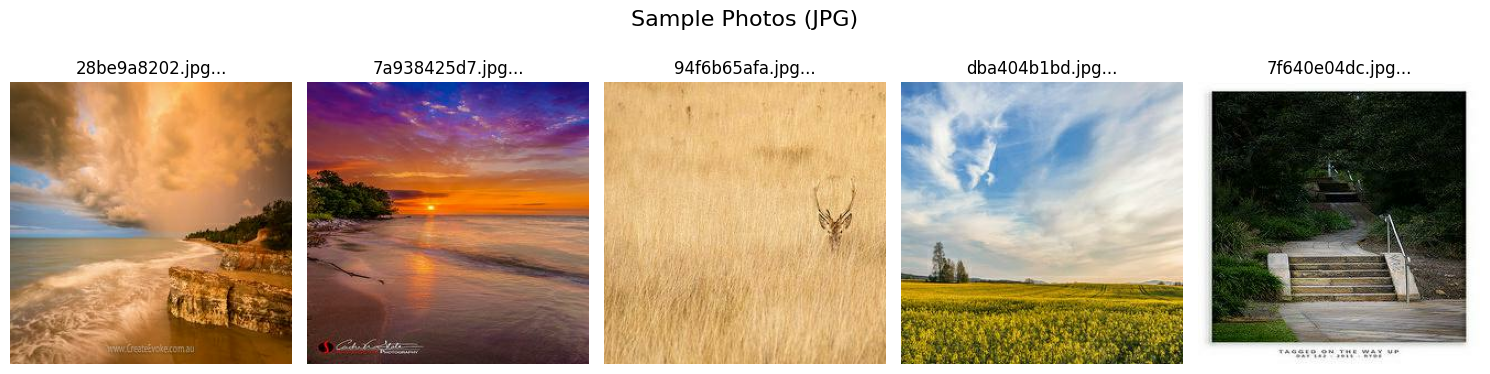

In [ ]:
# --- Inspection ---

# List files and count
monet_jpg_files = os.listdir(MONET_JPG_PATH)
photo_jpg_files = os.listdir(PHOTO_JPG_PATH)
print(f"Number of Monet JPG files found: {len(monet_jpg_files)}")
print(f"Number of Photo JPG files found: {len(photo_jpg_files)}")

# List TFRecord files
monet_tfrec_files = tf.io.gfile.glob(os.path.join(MONET_TFREC_PATH, '*.tfrec'))
photo_tfrec_files = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, '*.tfrec'))
print(f"Number of Monet TFRecord files found: {len(monet_tfrec_files)}")
print(f"Number of Photo TFRecord files found: {len(photo_tfrec_files)}")


# --- Visualization ---

# Function to display sample images
def display_samples(image_paths, num_samples=5, title="Sample Images"):

    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)
    random_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))

    for i, idx in enumerate(random_indices):
        img_path = image_paths[idx]
        plt.subplot(1, num_samples, i + 1)
        img_raw = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        plt.imshow(img)
        plt.title(os.path.basename(img_path)[:15]+"...") # Show start of filename
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Get full paths for visualization
monet_jpg_fullpaths = [os.path.join(MONET_JPG_PATH, f) for f in monet_jpg_files if f.lower().endswith('.jpg')]
photo_jpg_fullpaths = [os.path.join(PHOTO_JPG_PATH, f) for f in photo_jpg_files if f.lower().endswith('.jpg')]

# Display samples if paths exist
display_samples(monet_jpg_fullpaths, num_samples=5, title="Sample Monet Paintings (JPG)")
display_samples(photo_jpg_fullpaths, num_samples=5, title="Sample Photos (JPG)")

# EDA Summary and Preprocessing Discussion¶

* **File Counts**: The number of JPG files matches the competition description (300
Monet, ~7k Photos).
* Image Dimensions: Sample images confirmed the expected 256x256x3 shape.
* **Visual Inspection**: The sample images clearly show the two distinct domains: Monet's impressionist paintings and standard landscape photographs.
* **Format Choice**: We will use the TFRecord files (monet_tfrec, photo_tfrec) for training as they are generally more efficient for TensorFlow data pipelines, especially with accelerators (GPU/TPU).
* **Preprocessing Steps**:

1. **Decoding**: TFRecord files need to be parsed to extract the image data.
2. **Normalization**: Image pixel values (currently uint8 [0, 255]) must be normalized to the range [-1, 1] (common practice for GANs using tanh activation in the generator's output layer). This will be done by casting to float32 and applying (image / 127.5) - 1.0.
3. **Data Type**: Ensure images are tf.float32.
4. **Shuffling & Batching**: The tf.data.Dataset pipeline will handle shuffling and batching.
5. **Data Augmentation**: For CycleGAN, light augmentation like random horizontal flips can be applied to both datasets during loading to potentially improve generalization. We might add random jitter (slight resizing and cropping) as well, common in CycleGAN implementations.

# Data Loading and Preprocessing Pipeline

Create tf.data.Dataset pipelines to efficiently load, decode, and preprocess images from TFRecord files.


--- Loading Datasets ---
Number of Monet samples (from TFRecords): 300
Number of Photo samples (from TFRecords): 7038
Calculated steps per epoch: 150

Monet dataset element spec: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Photo dataset element spec: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Combined training dataset element spec: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


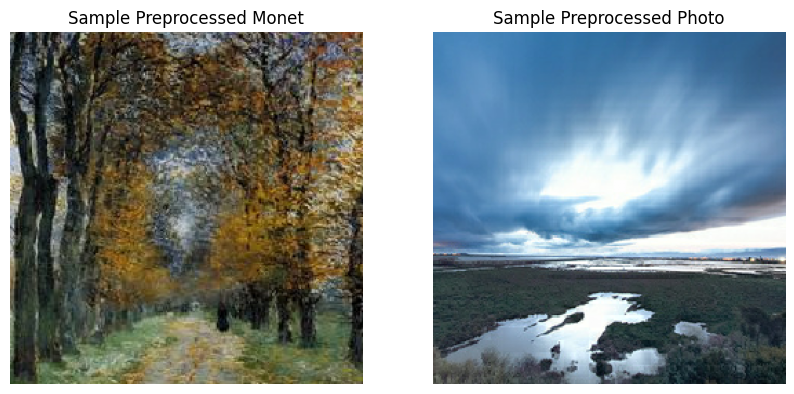

In [ ]:
# --- TFRecord Parsing and Preprocessing Functions ---

def decode_tfrecord(record_bytes):
    """Parses a single TFRecord and decodes the JPEG image."""
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string)
    })
    image = tf.io.decode_jpeg(features['image'], channels=3)
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    # Cast to float32 for normalization
    image = tf.cast(image, tf.float32)
    return image

def normalize_image(image):
    """Normalizes image pixel values to the range [-1, 1]."""
    image = (image / 127.5) - 1.0
    return image

def random_jitter(image):
    """Applies random jitter: resizing and random cropping."""
    # Resize to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Randomly crop to 256 x 256 x 3
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    # Random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_train(image):
    """Applies jitter and normalization for training."""
    image = random_jitter(image)
    image = normalize_image(image)
    return image

def preprocess_image_test(image):
    """Applies only normalization for testing/generation."""
    image = normalize_image(image)
    return image


# --- Dataset Creation Function ---

def load_dataset(tfrecord_files, train=True, shuffle=True):
    """Creates a tf.data.Dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    # Map decoding and preprocessing
    if train:
        dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    else: # For generation/testing, don't apply jitter
        dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# --- Load the Datasets ---
print("\n--- Loading Datasets ---")
monet_ds = load_dataset(monet_tfrec_files, train=True, shuffle=True)
photo_ds = load_dataset(photo_tfrec_files, train=True, shuffle=True)

# Combine datasets for paired iteration during training
full_dataset = tf.data.Dataset.zip((monet_ds.repeat(), photo_ds.repeat()))

def count_data_items(filenames):
    """Counts the total number of records across TFRecord files."""
    n = [int(tf.data.TFRecordDataset(fn).reduce(np.int64(0), lambda x, _: x + 1)) for fn in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(monet_tfrec_files)
n_photo_samples = count_data_items(photo_tfrec_files)
print(f"Number of Monet samples (from TFRecords): {n_monet_samples}")
print(f"Number of Photo samples (from TFRecords): {n_photo_samples}")

# Determine steps per epoch based on the larger dataset size for CycleGAN
steps_per_epoch = 150 # max(n_monet_samples, n_photo_samples) // BATCH_SIZE
print(f"Calculated steps per epoch: {steps_per_epoch}")


print(f"\nMonet dataset element spec: {monet_ds.element_spec}")
print(f"Photo dataset element spec: {photo_ds.element_spec}")
print(f"Combined training dataset element spec: {full_dataset.element_spec}")

# Visualize one preprocessed sample from each dataset
sample_monet_batch = next(iter(monet_ds))
sample_photo_batch = next(iter(photo_ds))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((sample_monet_batch[0].numpy() + 1.0) * 0.5)
plt.title("Sample Preprocessed Monet")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow((sample_photo_batch[0].numpy() + 1.0) * 0.5)
plt.title("Sample Preprocessed Photo")
plt.axis('off')
plt.show()


# Model Architecture (CycleGAN)¶


**Defining the building blocks and the main Generator and Discriminator models.**

* Generator: Uses a U-Net like architecture with downsampling (encoder) and
upsampling (decoder) blocks connected by skip connections. This helps preserve details during translation. Layer Normalization is used as a fallback for Instance Normalization.
* Discriminator: Uses a PatchGAN architecture. Instead of classifying the entire image as real or fake, it classifies overlapping patches (e.g., 70x70) of the image. This encourages the generator to produce realistic details across the whole image. It outputs a feature map where each value represents the "realness" of a patch. Layer Normalization is used here as well.

In [ ]:
# --- Model Architecture Components ---

# Fallback to LayerNormalization
NormalizationLayer = lambda: layers.LayerNormalization(axis=[1, 2])


# --- Building Blocks ---
def downsample(filters, size, apply_norm=True, name=None):
    """Downsampling block: Conv2D -> Norm -> LeakyReLU"""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential(name=name)
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(NormalizationLayer())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False, name=None):
    """Upsampling block: Conv2DTranspose -> Norm -> Dropout -> ReLU"""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential(name=name)
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    result.add(NormalizationLayer())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# --- Generator Model (U-Net based) ---
def build_generator(name="generator"):
    """Builds the Generator model (U-Net architecture)."""
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling path (Encoder)
    down_stack = [
        downsample(64, 4, apply_norm=False, name="down_1"),
        downsample(128, 4, name="down_2"),
        downsample(256, 4, name="down_3"),
        downsample(512, 4, name="down_4"),
        downsample(512, 4, name="down_5"),
        downsample(512, 4, name="down_6"),
        downsample(512, 4, name="down_7"),
        downsample(512, 4, name="down_8"),
    ]

    # Upsampling path (Decoder)
    up_stack = [
        upsample(512, 4, apply_dropout=True, name="up_1"),
        upsample(512, 4, apply_dropout=True, name="up_2"),
        upsample(512, 4, apply_dropout=True, name="up_3"),
        upsample(512, 4, name="up_4"),
        upsample(256, 4, name="up_5"),
        upsample(128, 4, name="up_6"),
        upsample(64, 4, name="up_7"),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # Final output layer
    last = layers.Conv2DTranspose(IMG_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh', name="output_image")

    x = inputs
    skips = []
    # Connect encoder to decoder with skip connections
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Build decoder path with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x, name=name)

# --- Discriminator Model (PatchGAN) ---
def build_discriminator(name="discriminator"):
    """Builds the Discriminator model (PatchGAN architecture)."""
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], name='input_image')

    # PatchGAN Structure
    x = downsample(64, 4, False, name="down_1")(inp)
    x = downsample(128, 4, name="down_2")(x)
    x = downsample(256, 4, name="down_3")(x)

    # Add padding before the next convolution
    x = layers.ZeroPadding2D(name="pad_1")(x)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=initializer,
                      use_bias=False, name="conv_1")(x)

    # Apply normalization after convolution
    x = NormalizationLayer()(x)
    x = layers.LeakyReLU(name="leaky_relu")(x)

    # Add padding before the final convolution
    x = layers.ZeroPadding2D(name="pad_2")(x)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer, name="output_patch")(x)

    return tf.keras.Model(inputs=inp, outputs=last, name=name)


# --- Instantiate Models ---
# Generator G: Photo -> Monet
# Generator F: Monet -> Photo
# Discriminator D_Y: Discriminates real/fake Monet
# Discriminator D_X: Discriminates real/fake Photo

monet_generator = build_generator(name="monet_generator")       # G
photo_generator = build_generator(name="photo_generator")       # F

monet_discriminator = build_discriminator(name="monet_discriminator") # D_Y
photo_discriminator = build_discriminator(name="photo_discriminator") # D_X


# Loss Functions and Optimizers

Defining the loss functions required for CycleGAN training:

* **Adversarial Loss**: Measures how well the generators fool the discriminators
and how well discriminators distinguish real from fake. Uses Binary Cross-Entropy with logits (from_logits=True) because the PatchGAN discriminators don't have a final sigmoid activation.
* **Cycle Consistency Loss**: Enforces the idea that translating an image to the other domain and back should yield the original image. Uses L1 loss (Mean Absolute Error) as it often produces less blurry results than L2. Weighted by LAMBDA_CYCLE.
* **Identity Loss**: Encourages the generator to preserve the color profile and characteristics of the input image when it's already in the target domain (e.g., feeding a Monet painting to the Monet generator should ideally result in the same painting). Also uses L1 loss. Weighted by LAMBDA_CYCLE * LAMBDA_IDENTITY. This loss is optional but often helps stabilize training.
We use the Adam optimizer for all four models.

In [ ]:
# --- Loss Functions ---
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    """Calculates discriminator loss."""
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated_output_from_discriminator):
    """Calculates generator adversarial loss."""
    return loss_obj(tf.ones_like(generated_output_from_discriminator), generated_output_from_discriminator)

def calc_cycle_loss(real_image, cycled_image):
    """Calculates cycle consistency loss (L1)."""
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss1

def calc_identity_loss(real_image, same_image):
    """Calculates identity loss (L1)."""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_CYCLE * LAMBDA_IDENTITY * loss


# --- Optimizers ---
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Monet Generator (G)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Photo Generator (F)

discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Monet Discriminator (D_Y)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Photo Discriminator (D_X)

# Training

**Checkpoints:** Set up TensorFlow checkpoints to save model weights periodically during training. This allows resuming training if interrupted and loading the best weights later.

In [ ]:
# --- Checkpoints ---
checkpoint_path = "./checkpoints/train"
os.makedirs(checkpoint_path, exist_ok=True)

ckpt = tf.train.Checkpoint(monet_generator=monet_generator,
                           photo_generator=photo_generator,
                           monet_discriminator=monet_discriminator,
                           photo_discriminator=photo_discriminator,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore the latest checkpoint if it exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
    print (f'Latest checkpoint restored from {ckpt_manager.latest_checkpoint}')
else:
    print('Initializing from scratch.')

Initializing from scratch.


In [ ]:
# --- Training Step Definition ---
@tf.function
def train_step(real_x, real_y):
    """Performs a single training step for the CycleGAN."""
    # real_x: real photo, real_y: real monet
    with tf.GradientTape(persistent=True) as tape:
        # --- Forward Pass ---
        # Generator G translates X (Photo) -> Y (Monet)
        # Generator F translates Y (Monet) -> X (Photo)

        fake_y = monet_generator(real_x, training=True)    # G(X) -> Fake Monet
        cycled_x = photo_generator(fake_y, training=True)  # F(G(X)) -> Cycled Photo

        fake_x = photo_generator(real_y, training=True)    # F(Y) -> Fake Photo
        cycled_y = monet_generator(fake_x, training=True)  # G(F(Y)) -> Cycled Monet

        # Identity mapping (input should ideally remain unchanged)
        same_y = monet_generator(real_y, training=True)    # G(Y) should be ~ Y
        same_x = photo_generator(real_x, training=True)    # F(X) should be ~ X

        # --- Discriminator Outputs ---
        disc_real_y = monet_discriminator(real_y, training=True) # D_Y(Y)
        disc_fake_y = monet_discriminator(fake_y, training=True) # D_Y(G(X))

        disc_real_x = photo_discriminator(real_x, training=True) # D_X(X)
        disc_fake_x = photo_discriminator(fake_x, training=True) # D_X(F(Y))

        # --- Calculate Losses ---
        # Generator Adversarial Loss
        gen_g_adv_loss = generator_loss(disc_fake_y) # G wants D_Y to think fake_y is real
        gen_f_adv_loss = generator_loss(disc_fake_x) # F wants D_X to think fake_x is real

        # Cycle Consistency Loss (Forward and Backward)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Identity Loss
        total_identity_loss = calc_identity_loss(real_y, same_y) + calc_identity_loss(real_x, same_x)

        # Total Generator Loss
        total_gen_g_loss = gen_g_adv_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_adv_loss + total_cycle_loss + total_identity_loss

        # Discriminator Loss
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # D_Y loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # D_X loss

    # --- Calculate Gradients ---
    # Generator gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, monet_generator.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, photo_generator.trainable_variables)

    # Discriminator gradients
    discriminator_y_gradients = tape.gradient(disc_y_loss, monet_discriminator.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, photo_discriminator.trainable_variables)

    # --- Apply Gradients ---
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, monet_generator.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, photo_generator.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, monet_discriminator.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, photo_discriminator.trainable_variables))

    # Return losses for monitoring
    return {
        "gen_G_loss": total_gen_g_loss, "gen_F_loss": total_gen_f_loss,
        "disc_Y_loss": disc_y_loss, "disc_X_loss": disc_x_loss,
        "cycle_loss": total_cycle_loss, "identity_loss": total_identity_loss,
        "gen_G_adv_loss": gen_g_adv_loss, "gen_F_adv_loss": gen_f_adv_loss
    }

# Training Loop

In [ ]:
# --- Function to Generate and Display Images During Training ---
sample_photo_batch_vis = next(iter(load_dataset(photo_tfrec_files, train=False, shuffle=False).take(1)))

def generate_images(model, test_input, epoch, step):
    """Generates and displays a sample transformed image."""
    prediction = model(test_input, training=False)[0].numpy()

    plt.figure(figsize=(10, 5))

    display_input = (test_input[0].numpy() + 1.0) * 0.5
    display_prediction = (prediction + 1.0) * 0.5

    title = ['Input Photo', 'Generated Monet Style']

    plt.subplot(1, 2, 1)
    plt.title(title[0])
    plt.imshow(np.clip(display_input, 0, 1))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title[1])
    plt.imshow(np.clip(display_prediction, 0, 1))
    plt.axis('off')

    plt.suptitle(f"Epoch: {epoch+1}, Step: {step}", fontsize=14)
    plt.show()


# --- Training Loop ---
print("\n--- Starting Training ---")
print(f"Total Epochs: {EPOCHS}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Frequency for printing losses and generating sample images
print_freq = 100
sample_freq = 500

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    step_pbar = tqdm(total=steps_per_epoch, desc=f"Epoch {epoch+1} Steps")

    # Initialize epoch losses dictionary using tf.keras.metrics.Mean
    epoch_losses = {k: tf.keras.metrics.Mean() for k in [
        "gen_G_loss", "gen_F_loss", "disc_Y_loss", "disc_X_loss",
        "cycle_loss", "identity_loss", "gen_G_adv_loss", "gen_F_adv_loss"
    ]}

    # Iterate through the zipped dataset for the calculated number of steps
    for step, (real_monet, real_photo) in enumerate(full_dataset.take(steps_per_epoch)):
        if step >= steps_per_epoch: break

        # Perform one training step
        losses = train_step(real_photo, real_monet)

        # Update epoch average losses
        for k, v in losses.items():
            if k in epoch_losses:
                epoch_losses[k].update_state(v)
            else:
                print(f"Warning: Loss key '{k}' not found in epoch_losses dictionary.")


        # Print progress periodically
        if (step + 1) % print_freq == 0:
            # Format loss string using the result() method of the metrics
            loss_str = ", ".join([f"{k}={v.result():.4f}" for k, v in epoch_losses.items()])
            print(f'> Step {step+1}/{steps_per_epoch}: {loss_str}')

        # Generate and show a sample image periodically
        if (step + 1) % sample_freq == 0:
             print(f"\nGenerating sample image at step {step+1}...")
             generate_images(monet_generator, sample_photo_batch_vis, epoch, step+1)

        step_pbar.update(1)

    step_pbar.close()

    # Print average losses for the completed epoch
    print(f"Epoch {epoch+1} Average Losses: ", end="")
    avg_loss_str = ", ".join([f"{k}={v.result():.4f}" for k, v in epoch_losses.items()])
    print(avg_loss_str)

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    # Save the last epoch as well
    elif epoch == EPOCHS - 1:
         ckpt_save_path = ckpt_manager.save()
         print(f'Saving final checkpoint for epoch {epoch+1} at {ckpt_save_path}')


    end_time = time.time()
    print(f'Time taken for epoch {epoch + 1}: {end_time - start_time:.2f} sec')

    # Reset metrics at the end of each epoch
    for k in epoch_losses:
        epoch_losses[k].reset_state()


--- Starting Training ---
Total Epochs: 25
Steps per Epoch: 150

Epoch 1/25


Epoch 1 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=8.1733, gen_F_loss=8.1280, disc_Y_loss=0.7554, disc_X_loss=0.7400, cycle_loss=5.0782, identity_loss=2.2748, gen_G_adv_loss=0.8203, gen_F_adv_loss=0.7750
Epoch 1 Average Losses: gen_G_loss=7.2754, gen_F_loss=7.2368, disc_Y_loss=0.7285, disc_X_loss=0.7204, cycle_loss=4.4739, identity_loss=1.9840, gen_G_adv_loss=0.8175, gen_F_adv_loss=0.7788
Time taken for epoch 1: 840.87 sec

Epoch 2/25


Epoch 2 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=4.8611, gen_F_loss=4.7835, disc_Y_loss=0.6568, disc_X_loss=0.6779, cycle_loss=2.7242, identity_loss=1.2182, gen_G_adv_loss=0.9187, gen_F_adv_loss=0.8411
Epoch 2 Average Losses: gen_G_loss=4.7696, gen_F_loss=4.6802, disc_Y_loss=0.6560, disc_X_loss=0.6729, cycle_loss=2.6622, identity_loss=1.1930, gen_G_adv_loss=0.9144, gen_F_adv_loss=0.8250
Time taken for epoch 2: 770.99 sec

Epoch 3/25


Epoch 3 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=4.3297, gen_F_loss=4.2876, disc_Y_loss=0.6367, disc_X_loss=0.6507, cycle_loss=2.3116, identity_loss=1.0922, gen_G_adv_loss=0.9259, gen_F_adv_loss=0.8838
Epoch 3 Average Losses: gen_G_loss=4.2678, gen_F_loss=4.2147, disc_Y_loss=0.6597, disc_X_loss=0.6670, cycle_loss=2.2892, identity_loss=1.0814, gen_G_adv_loss=0.8971, gen_F_adv_loss=0.8440
Time taken for epoch 3: 756.98 sec

Epoch 4/25


Epoch 4 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=4.0546, gen_F_loss=3.9883, disc_Y_loss=0.6396, disc_X_loss=0.6567, cycle_loss=2.1527, identity_loss=0.9971, gen_G_adv_loss=0.9048, gen_F_adv_loss=0.8385
Epoch 4 Average Losses: gen_G_loss=4.0585, gen_F_loss=3.9978, disc_Y_loss=0.6458, disc_X_loss=0.6599, cycle_loss=2.1491, identity_loss=1.0107, gen_G_adv_loss=0.8988, gen_F_adv_loss=0.8381
Time taken for epoch 4: 742.07 sec

Epoch 5/25


Epoch 5 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.8997, gen_F_loss=3.8887, disc_Y_loss=0.6659, disc_X_loss=0.6679, cycle_loss=2.0628, identity_loss=0.9916, gen_G_adv_loss=0.8452, gen_F_adv_loss=0.8343
Epoch 5 Average Losses: gen_G_loss=3.8815, gen_F_loss=3.8667, disc_Y_loss=0.6504, disc_X_loss=0.6586, cycle_loss=2.0393, identity_loss=0.9672, gen_G_adv_loss=0.8750, gen_F_adv_loss=0.8602
Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Time taken for epoch 5: 741.46 sec

Epoch 6/25


Epoch 6 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.7074, gen_F_loss=3.6848, disc_Y_loss=0.6563, disc_X_loss=0.6586, cycle_loss=1.9098, identity_loss=0.9058, gen_G_adv_loss=0.8918, gen_F_adv_loss=0.8693
Epoch 6 Average Losses: gen_G_loss=3.7668, gen_F_loss=3.7281, disc_Y_loss=0.6531, disc_X_loss=0.6602, cycle_loss=1.9308, identity_loss=0.9222, gen_G_adv_loss=0.9138, gen_F_adv_loss=0.8751
Time taken for epoch 6: 771.35 sec

Epoch 7/25


Epoch 7 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.6319, gen_F_loss=3.6195, disc_Y_loss=0.6552, disc_X_loss=0.6638, cycle_loss=1.9159, identity_loss=0.8708, gen_G_adv_loss=0.8452, gen_F_adv_loss=0.8328
Epoch 7 Average Losses: gen_G_loss=3.6349, gen_F_loss=3.5947, disc_Y_loss=0.6582, disc_X_loss=0.6689, cycle_loss=1.8965, identity_loss=0.8726, gen_G_adv_loss=0.8659, gen_F_adv_loss=0.8256
Time taken for epoch 7: 747.73 sec

Epoch 8/25


Epoch 8 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.5374, gen_F_loss=3.4851, disc_Y_loss=0.6512, disc_X_loss=0.6531, cycle_loss=1.7982, identity_loss=0.8363, gen_G_adv_loss=0.9029, gen_F_adv_loss=0.8506
Epoch 8 Average Losses: gen_G_loss=3.5895, gen_F_loss=3.5440, disc_Y_loss=0.6468, disc_X_loss=0.6497, cycle_loss=1.8247, identity_loss=0.8579, gen_G_adv_loss=0.9068, gen_F_adv_loss=0.8614
Time taken for epoch 8: 760.93 sec

Epoch 9/25


Epoch 9 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.5611, gen_F_loss=3.5543, disc_Y_loss=0.6435, disc_X_loss=0.6511, cycle_loss=1.8036, identity_loss=0.8522, gen_G_adv_loss=0.9053, gen_F_adv_loss=0.8984
Epoch 9 Average Losses: gen_G_loss=3.5439, gen_F_loss=3.5100, disc_Y_loss=0.6377, disc_X_loss=0.6458, cycle_loss=1.7877, identity_loss=0.8428, gen_G_adv_loss=0.9134, gen_F_adv_loss=0.8795
Time taken for epoch 9: 802.07 sec

Epoch 10/25


Epoch 10 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.4040, gen_F_loss=3.3447, disc_Y_loss=0.6521, disc_X_loss=0.6573, cycle_loss=1.7004, identity_loss=0.7952, gen_G_adv_loss=0.9083, gen_F_adv_loss=0.8490
Epoch 10 Average Losses: gen_G_loss=3.5146, gen_F_loss=3.4744, disc_Y_loss=0.6415, disc_X_loss=0.6446, cycle_loss=1.7359, identity_loss=0.8365, gen_G_adv_loss=0.9422, gen_F_adv_loss=0.9020
Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10: 758.60 sec

Epoch 11/25


Epoch 11 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.4538, gen_F_loss=3.4109, disc_Y_loss=0.6213, disc_X_loss=0.6300, cycle_loss=1.6765, identity_loss=0.8173, gen_G_adv_loss=0.9599, gen_F_adv_loss=0.9171
Epoch 11 Average Losses: gen_G_loss=3.4794, gen_F_loss=3.4546, disc_Y_loss=0.6283, disc_X_loss=0.6328, cycle_loss=1.6727, identity_loss=0.8380, gen_G_adv_loss=0.9686, gen_F_adv_loss=0.9438
Time taken for epoch 11: 762.60 sec

Epoch 12/25


Epoch 12 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1841, gen_F_loss=3.1573, disc_Y_loss=0.6510, disc_X_loss=0.6540, cycle_loss=1.5675, identity_loss=0.7317, gen_G_adv_loss=0.8849, gen_F_adv_loss=0.8581
Epoch 12 Average Losses: gen_G_loss=3.2199, gen_F_loss=3.1950, disc_Y_loss=0.6667, disc_X_loss=0.6613, cycle_loss=1.5944, identity_loss=0.7535, gen_G_adv_loss=0.8720, gen_F_adv_loss=0.8470
Time taken for epoch 12: 748.02 sec

Epoch 13/25


Epoch 13 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2655, gen_F_loss=3.2312, disc_Y_loss=0.6295, disc_X_loss=0.6471, cycle_loss=1.5884, identity_loss=0.7525, gen_G_adv_loss=0.9245, gen_F_adv_loss=0.8902
Epoch 13 Average Losses: gen_G_loss=3.2890, gen_F_loss=3.2788, disc_Y_loss=0.6350, disc_X_loss=0.6456, cycle_loss=1.6060, identity_loss=0.7664, gen_G_adv_loss=0.9166, gen_F_adv_loss=0.9064
Time taken for epoch 13: 739.19 sec

Epoch 14/25


Epoch 14 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2057, gen_F_loss=3.1497, disc_Y_loss=0.6408, disc_X_loss=0.6451, cycle_loss=1.5258, identity_loss=0.7383, gen_G_adv_loss=0.9416, gen_F_adv_loss=0.8856
Epoch 14 Average Losses: gen_G_loss=3.2593, gen_F_loss=3.2189, disc_Y_loss=0.6255, disc_X_loss=0.6315, cycle_loss=1.5443, identity_loss=0.7523, gen_G_adv_loss=0.9627, gen_F_adv_loss=0.9224
Time taken for epoch 14: 736.54 sec

Epoch 15/25


Epoch 15 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2101, gen_F_loss=3.1789, disc_Y_loss=0.6368, disc_X_loss=0.6415, cycle_loss=1.5022, identity_loss=0.7417, gen_G_adv_loss=0.9661, gen_F_adv_loss=0.9349
Epoch 15 Average Losses: gen_G_loss=3.2307, gen_F_loss=3.1961, disc_Y_loss=0.6282, disc_X_loss=0.6370, cycle_loss=1.5210, identity_loss=0.7471, gen_G_adv_loss=0.9626, gen_F_adv_loss=0.9280
Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Time taken for epoch 15: 744.64 sec

Epoch 16/25


Epoch 16 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2720, gen_F_loss=3.2252, disc_Y_loss=0.6481, disc_X_loss=0.6401, cycle_loss=1.5400, identity_loss=0.7782, gen_G_adv_loss=0.9538, gen_F_adv_loss=0.9070
Epoch 16 Average Losses: gen_G_loss=3.2265, gen_F_loss=3.1940, disc_Y_loss=0.6414, disc_X_loss=0.6380, cycle_loss=1.5235, identity_loss=0.7628, gen_G_adv_loss=0.9403, gen_F_adv_loss=0.9077
Time taken for epoch 16: 759.59 sec

Epoch 17/25


Epoch 17 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1160, gen_F_loss=3.1111, disc_Y_loss=0.6389, disc_X_loss=0.6396, cycle_loss=1.4859, identity_loss=0.7208, gen_G_adv_loss=0.9093, gen_F_adv_loss=0.9044
Epoch 17 Average Losses: gen_G_loss=3.1152, gen_F_loss=3.1088, disc_Y_loss=0.6407, disc_X_loss=0.6401, cycle_loss=1.4951, identity_loss=0.7226, gen_G_adv_loss=0.8976, gen_F_adv_loss=0.8911
Time taken for epoch 17: 765.27 sec

Epoch 18/25


Epoch 18 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1300, gen_F_loss=3.1166, disc_Y_loss=0.6187, disc_X_loss=0.6129, cycle_loss=1.4732, identity_loss=0.6988, gen_G_adv_loss=0.9580, gen_F_adv_loss=0.9446
Epoch 18 Average Losses: gen_G_loss=3.1645, gen_F_loss=3.1526, disc_Y_loss=0.6353, disc_X_loss=0.6363, cycle_loss=1.5034, identity_loss=0.7266, gen_G_adv_loss=0.9345, gen_F_adv_loss=0.9225
Time taken for epoch 18: 802.06 sec

Epoch 19/25


Epoch 19 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.0705, gen_F_loss=3.0341, disc_Y_loss=0.6312, disc_X_loss=0.6326, cycle_loss=1.4282, identity_loss=0.6795, gen_G_adv_loss=0.9628, gen_F_adv_loss=0.9264
Epoch 19 Average Losses: gen_G_loss=3.1510, gen_F_loss=3.1363, disc_Y_loss=0.6287, disc_X_loss=0.6345, cycle_loss=1.4874, identity_loss=0.7038, gen_G_adv_loss=0.9598, gen_F_adv_loss=0.9450
Time taken for epoch 19: 754.21 sec

Epoch 20/25


Epoch 20 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.0953, gen_F_loss=3.0803, disc_Y_loss=0.6358, disc_X_loss=0.6293, cycle_loss=1.4567, identity_loss=0.7039, gen_G_adv_loss=0.9346, gen_F_adv_loss=0.9197
Epoch 20 Average Losses: gen_G_loss=3.1033, gen_F_loss=3.1037, disc_Y_loss=0.6340, disc_X_loss=0.6241, cycle_loss=1.4600, identity_loss=0.7081, gen_G_adv_loss=0.9352, gen_F_adv_loss=0.9356
Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20: 761.30 sec

Epoch 21/25


Epoch 21 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1045, gen_F_loss=3.1229, disc_Y_loss=0.6325, disc_X_loss=0.6324, cycle_loss=1.4599, identity_loss=0.7148, gen_G_adv_loss=0.9298, gen_F_adv_loss=0.9482
Epoch 21 Average Losses: gen_G_loss=3.0503, gen_F_loss=3.0668, disc_Y_loss=0.6425, disc_X_loss=0.6407, cycle_loss=1.4458, identity_loss=0.7017, gen_G_adv_loss=0.9028, gen_F_adv_loss=0.9193
Time taken for epoch 21: 764.00 sec

Epoch 22/25


Epoch 22 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=2.9612, gen_F_loss=3.0031, disc_Y_loss=0.6425, disc_X_loss=0.6319, cycle_loss=1.4137, identity_loss=0.6708, gen_G_adv_loss=0.8767, gen_F_adv_loss=0.9185
Epoch 22 Average Losses: gen_G_loss=3.0361, gen_F_loss=3.0620, disc_Y_loss=0.6262, disc_X_loss=0.6136, cycle_loss=1.4221, identity_loss=0.6904, gen_G_adv_loss=0.9236, gen_F_adv_loss=0.9495
Time taken for epoch 22: 754.83 sec

Epoch 23/25


Epoch 23 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.0913, gen_F_loss=3.1376, disc_Y_loss=0.6360, disc_X_loss=0.6194, cycle_loss=1.4567, identity_loss=0.6987, gen_G_adv_loss=0.9358, gen_F_adv_loss=0.9822
Epoch 23 Average Losses: gen_G_loss=3.0438, gen_F_loss=3.0917, disc_Y_loss=0.6429, disc_X_loss=0.6261, cycle_loss=1.4412, identity_loss=0.6883, gen_G_adv_loss=0.9143, gen_F_adv_loss=0.9622
Time taken for epoch 23: 753.85 sec

Epoch 24/25


Epoch 24 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1005, gen_F_loss=3.1261, disc_Y_loss=0.6193, disc_X_loss=0.5938, cycle_loss=1.4557, identity_loss=0.6971, gen_G_adv_loss=0.9477, gen_F_adv_loss=0.9733
Epoch 24 Average Losses: gen_G_loss=3.0785, gen_F_loss=3.1111, disc_Y_loss=0.6317, disc_X_loss=0.6157, cycle_loss=1.4557, identity_loss=0.6930, gen_G_adv_loss=0.9297, gen_F_adv_loss=0.9623
Time taken for epoch 24: 750.71 sec

Epoch 25/25


Epoch 25 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.0203, gen_F_loss=3.0918, disc_Y_loss=0.6257, disc_X_loss=0.5961, cycle_loss=1.4347, identity_loss=0.6755, gen_G_adv_loss=0.9102, gen_F_adv_loss=0.9817
Epoch 25 Average Losses: gen_G_loss=3.0311, gen_F_loss=3.1032, disc_Y_loss=0.6324, disc_X_loss=0.6090, cycle_loss=1.4454, identity_loss=0.6886, gen_G_adv_loss=0.8971, gen_F_adv_loss=0.9692
Saving checkpoint for epoch 25 at ./checkpoints/train/ckpt-5
Time taken for epoch 25: 751.93 sec


# Image Generation and Submission File Creation

In [ ]:
# --- Generate Monet-Style Images for Submission ---
print("\n--- Generating Submission Images ---")

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create a dataset for the photos to be transformed (use non-augmented preprocessing)
submission_photo_ds = load_dataset(photo_tfrec_files, train=False, shuffle=False)

# Counter for generated images
img_count = 0
max_images = 10000 # Competition requires 7k-10k images

# Use tqdm for progress bar
# Estimate total number of images to generate (can be slightly off if batch size > 1)
total_gen_images = n_photo_samples * BATCH_SIZE
generation_pbar = tqdm(total=min(total_gen_images, max_images), desc="Generating Images")

# Iterate through the photo dataset batches
for photo_batch in submission_photo_ds:
    # Generate Monet-style images using the trained generator
    generated_batch = monet_generator(photo_batch, training=False)

    # Process each image in the batch (batch size is likely 1 here)
    for i in range(generated_batch.shape[0]):
        if img_count >= max_images:
            break

        # Get single generated image
        generated_img = generated_batch[i].numpy()

        # Denormalize: Convert from [-1, 1] back to [0, 255] uint8
        generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)

        # Create PIL Image object
        img_pil = Image.fromarray(generated_img)

        # Save the image as JPG in the output directory
        output_filepath = os.path.join(OUTPUT_DIR, f"image_{img_count+1}.jpg")
        try:
            img_pil.save(output_filepath, format='JPEG')
            img_count += 1
            generation_pbar.update(1) # Update progress for each image SAVED
        except Exception as e:
            print(f"Error saving image {img_count+1}: {e}")


    if img_count >= max_images:
        print(f"\nReached maximum image limit ({max_images}). Stopping generation.")
        break

generation_pbar.close()
print(f"\nGenerated {img_count} images in {OUTPUT_DIR}")

# --- Create Submission Zip File ---
if img_count >= 7000: # Only create zip if enough images were generated
    print(f"\n--- Creating Submission Zip File: {ZIP_FILENAME} ---")
    try:
        with zipfile.ZipFile(ZIP_FILENAME, 'w', zipfile.ZIP_DEFLATED) as zf:
            # Walk through the output directory and add files to the zip
            for root, _, files in os.walk(OUTPUT_DIR):
                for file in tqdm(files, desc="Zipping Images"):
                    if file.lower().endswith('.jpg'):
                        file_path = os.path.join(root, file)
                        # ** FIX: Use OUTPUT_DIR as the base for relpath **
                        arcname = os.path.relpath(file_path, OUTPUT_DIR)
                        zf.write(file_path, arcname=arcname)
        print(f"Successfully created {ZIP_FILENAME}")

        # Optional: Verify zip file contents (list first few files)
        # with zipfile.ZipFile(ZIP_FILENAME, 'r') as zf:
        #     print("\nSample files in zip:")
        #     for i, name in enumerate(zf.namelist()):
        #         if i >= 5: break
        #         print(f"- {name}")

    except Exception as e:
        print(f"Error creating zip file: {e}")
else:
    print(f"\nSkipping zip file creation. Generated {img_count} images (minimum 7000 required).")


--- Generating Submission Images ---


Generating Images:   0%|          | 0/7038 [00:00<?, ?it/s]


Generated 7038 images in /kaggle/working/images/

--- Creating Submission Zip File: /kaggle/working/images.zip ---


Zipping Images:   0%|          | 0/7038 [00:00<?, ?it/s]

Successfully created /kaggle/working/images.zip
